In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


En primer lloc carreguem les dades dels dos darrers anys de cadascuna de les tres localitats: Chicago, Nova York i Los Angeles. 

In [2]:
nyc_crime = pd.read_csv('https://zenodo.org/record/3902827/files/NYPD_Complaint_Data_Historic_18_19.csv', sep=';')
print ("Carregades les dades de Nova York,", len(nyc_crime), "registres")
chi_crime = pd.read_csv('https://zenodo.org/record/3902623/files/Chicago_crimes_18-19.csv')
print ("Carregades les dades de Chicago,", len(chi_crime), "registres")
la_crime = pd.read_csv('https://zenodo.org/record/3902627/files/LA_Crime_Data_18_19.csv', sep=';')
print ("Carregades les dades de Los Angeles,", len(la_crime), "registres")

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Carregades les dades de Nova York, 1257371 registres
Carregades les dades de Chicago, 527130 registres
Carregades les dades de Los Angeles, 444470 registres


Cal analitzar els conjunts de dades de cadascuna de les ciutats, seleccionar les variables que interessin i transformar aquelles que estiguin en formats que no podem treballar. Per interpretar el contingut de les columnes, també tenim a la nostra disposició la informació dels portals de dades obertes d'on hem obtingut les dades. 

## Tractament de les dades de la ciutat de Nova York

In [3]:
print (nyc_crime.head())
print (nyc_crime.describe())
for col in nyc_crime.columns: 
    print (col, len(nyc_crime[col].unique()), nyc_crime[col].dtype)

   Unnamed: 0  CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
0     3018402   774621657   10/08/2018     12:30:00          NaN          NaN   
1     3018403   232548146   08/24/2018     11:00:00          NaN          NaN   
2     3018405   174510270   11/18/2019     13:40:00          NaN          NaN   
3     3018406   452701517   03/30/2018     16:55:00          NaN          NaN   
4     3018407   620357753   10/02/2018     16:00:00          NaN          NaN   

   ADDR_PCT_CD      RPT_DT  KY_CD          OFNS_DESC      ...        \
0         43.0  10/08/2018    105            ROBBERY      ...         
1         78.0  08/25/2018    341      PETIT LARCENY      ...         
2         52.0  11/18/2019    578      HARRASSMENT 2      ...         
3        114.0  03/30/2018    118  DANGEROUS WEAPONS      ...         
4        105.0  10/03/2018    341      PETIT LARCENY      ...         

   TRANSIT_DISTRICT   Latitude  Longitude  \
0               NaN  40.823836 -73.861624

https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

PENDENT DE COMPLETAR

<ul>
    <li>'DR_NO': És l'identificador de cada cas, les dades són de tipus int64, per tant, serà útil per identificar cada registre </li>
    <li>'Date Rptd': Data en què s'ha recollit la denúncia. No es considera útil i s'elimina. </li>
    <li>'DATE OCC': La data en què han passat o s'estima que han passat els fets. Cal transformar-ho a format de data i també s'extrauran altres variables relacionades amb la data. </li>
    <li>'TIME OCC': L'hora en què han passat o s'estima que han passat els fets. Cal transformar-ho a format dd'hora i es crearà un camp unificat amb la data per tenir un moment concret. </li>
    <li>'AREA ': Codi numèric de l'àrea policial on han passat els fets. N'hi ha 21. </li>
    <li>'AREA NAME': Nom de l'àrea policial on han passat els fets. N'hi ha 21 i corresponen amb els codis d'AREA. </li>
    <li>'Rpt Dist No': Codi numèric de la subàrea geogràfica. N'hi ha 1303 registres únics.</li>
    <li>'Part 1-2': Camp numèric amb dos valors únics, 1 i 2, encara que no s'ha pogut determinar a què corresponen. </li>
    <li>'Crm Cd': Codi del delicte comès, 142 valors diferents. </li>
    <li>'Crm Cd Desc': Descripció del delicte comès, 142 valors diferents.</li>
    <li>'Mocodes': Codis del modus operandi. Cada camp pot contenir més d'un codi. Inicialment no es tractarà amb aquesta informació, que caldria separar per poder analitzar-la de manera adequada. </li>
    <li>'Vict Age': Camp numèric amb l'edat de la víctima. Es descarta el seu ús. </li>
    <li>'Vict Sex': Camp amb el codi del sexe de la víctima (Dona, Home o desconegut). Es descarta el seu ús. </li>
    <li>'Vict Descent': Camp amb una codificació de lletra per identificar l'origen de la víctima. Es descarta el seu ús. </li>
    <li>'Premis Cd': Codi sobre el tipus de lloc on han passat els fets. 
    <li>'Premis Desc': Informació sobre el tipus lloc on han passat els fets. </li>
    <li>'Weapon Used Cd': Codi sobre el tipus d'arma utilitzat en el delicte. </li>
    <li>'Weapon Desc': Descripcío del tipus d'arma utilitzada.  </li>
    <li>'Status': Codi sobre l'estat del cas, indica, per exemple, si s'ha detingut una persona o si contniua la investigació (situació per defecte).  Es descarta el seu ús</li>
    <li>'Status Desc': Descripció de l'estat del cas, indica, per exemple, si s'ha detingut una persona o si contniua la investigació (situació per defecte). Es descarta el seu ús  </li>
    <li>'Crm Cd 1': Codi del fet principal que ha tingut lloc. </li>
    <li>'Crm Cd 2': Codi d'un eventual fet secundari que ha tingut lloc en el mateix fet. Caldria afegir noves línies per aquests fets. </li>
    <li>'Crm Cd 3': Codi d'un eventual fet terciari que ha tingut lloc en el mateix fet. Caldria afegir noves línies per aquests fets.</li>
    <li>'Crm Cd 4': Codi d'un eventual quart fet que ha tingut lloc en el mateix fet. Caldria afegir noves línies per aquests fets.</li>
    <li>'LOCATION': Adreça del lloc on han passat els fets. Es descarta aquest camp. </li>
    <li>'Cross Street': Creuament dels carrers. Es descarta aquest camp. </li>
    <li>'LAT' : Latitud del lloc dels fets. Igual que les coordenades, la ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases.</li>
    <li>'LON' : Longitud del lloc dels fets. Igual que les coordenades, la ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases.</li> 


In [4]:
nyc_crime = nyc_crime.drop(['CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'RPT_DT',
                            'CRM_ATPT_CPTD_CD', 'SUSP_AGE_GROUP', 
                            'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 
                            'VIC_RACE', 'VIC_SEX'], axis=1)

#Convert Dates
nyc_crime.replace("24:00:00", "00:00:00")

print (len(nyc_crime['CMPLNT_FR_DT']))
validDays= nyc_crime['CMPLNT_FR_DT'].dropna().unique()
nyc_crime = nyc_crime[nyc_crime['CMPLNT_FR_DT'].isin(validDays)]
nyc_crime['CMPLNT_FR_year'] = nyc_crime['CMPLNT_FR_DT'].fillna(0).apply(lambda x: int(x[-4:]))
nyc_crime = nyc_crime[nyc_crime['CMPLNT_FR_year']>2005]
nyc_crime['CMPLNT_FR_DT'] = pd.to_datetime(nyc_crime['CMPLNT_FR_DT'], format='%m/%d/%Y').dt.date
nyc_crime['CMPLNT_FR_TM'] = pd.to_datetime(nyc_crime['CMPLNT_FR_TM'], format='%H:%M:%S').dt.time

#PENDENT crear camp amb dia i hora

print (len(nyc_crime))
nyc_crime = nyc_crime[(nyc_crime['Latitude'] < 42) & (nyc_crime['Longitude'] > -75)]
print (len(nyc_crime))

1257371
1257371
937079


## Tractament de les dades de la ciutat de Chicago

In [5]:
print (chi_crime.head())
print (chi_crime.describe())
for col in chi_crime.columns: 
    print (col, len(chi_crime[col].unique()), chi_crime[col].dtype)

   Unnamed: 0        ID Case Number                    Date  \
0          45  11223717    JB141803  02/04/2018 03:25:00 PM   
1          55  11243511    JB168893  02/20/2018 04:21:00 PM   
2          64  11223707    JB141873  02/05/2018 12:00:00 AM   
3          66  11228287    JB148482  01/03/2018 03:45:00 PM   
4          88  11225457    JB144550  02/05/2018 06:00:00 PM   

                     Block  IUCR        Primary Type  \
0  044XX W WASHINGTON BLVD  1153  DECEPTIVE PRACTICE   
1     005XX W ARLINGTON PL  0820               THEFT   
2      061XX N KENMORE AVE  2820       OTHER OFFENSE   
3            0000X W C1 ST  0810               THEFT   
4      013XX N LA SALLE DR  0890               THEFT   

                           Description  \
0  FINANCIAL IDENTITY THEFT OVER $ 300   
1                       $500 AND UNDER   
2                     TELEPHONE THREAT   
3                            OVER $500   
4                        FROM BUILDING   

                             Lo

https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2 

<ul>
    <li>'ID': És l'identificador de cada cas, les dades són de tipus int64, per tant, serà útil per identificar cada registre </li>
    <li>'Case Number': És un identificació dels procediments. La xifra de registres únics és molt propera a la de l'identificador, per tant, probablement hi hagi algun valor repetit o nul. Les dades són alfanumèriques. La informació que aporta no ens resultarà d'utilitat, per tant eliminarem la columna. </li>
    <li>'Date': La data en què han passat o s'estima que han passat els fets. Cal transformar-ho a format de data i també s'extrauran altres variables relacionades amb la data. </li>
    <li>'Block': Informació sobre l'illa de cases on ha passat el fet. Es podria utilitzar com l'agrupació de punts més petita. </li>
    <li>'IUCR': Informació sobre el tipus de fet. Hi ha una gran quantitat de tipologies (402), i cal recòrrer a una informació externa per interpretar els codis.</li>
    <li>'Primary Type': Informació sobre els principals tipus de fet, són 36 categories, en format text.  </li>
    <li>'Description': Informació sobre els tipus de fet secundaris, són 517 categories, en format text.  </li>
    <li>'Location Description': Informació sobre el lloc on han passat els fets. </li>
    <li>'Arrest': Indica si s'ha produït una detenció. És una variable booleana. </li>
    <li>'Domestic': Informa si es tracta d'un fet de violència domèstica. És una variable booleana. </li>
    <li>'Beat': Informació geogràfica en relació a les zones de patrullage, que en són 304.  </li>
    <li>'District': Informació geogràfica en relació als districtes policials. N'hi ha 25 registres únics, malgrat que a la informació municipal en parla de 22. </li>
    <li>'Ward': Informació geogràfica que fa referència a districtes municipals, diferents dels districtes policials.(51) </li>
    <li>'Community Area': Una altra divisió territorial,amb àrees una mica més petites, ja que són 79 valors únics.   </li>
    <li>'FBI Code': Una altra classificació dels tipus de fets, en aquest cas de l'àmbit nacional dels EUA, i que té 26 tipus de fets.  </li>
    <li>'X Coordinate': Coordenada X del lloc on ha passat el fet, en la projeccio NAD 1983. La ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases. </li>
    <li>'Y Coordinate': Coordenada Y del lloc on ha passat el fet, en la projeccio NAD 1983. La ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases. </li>
    <li>'Updated On': Data en què s'ha actualitzat el registre. No es considera útil i s'elimina. </li>
    <li>'Latitude' : Latitud del lloc dels fets. Igual que les coordenades, la ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases.</li>
    <li>'Longitude' : Longitud del lloc dels fets. Igual que les coordenades, la ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases.</li> 
    <li>'Location' : Tupla amb la latitud i la longitud. Atès que la informació està en altres camps, s'omet també aquesta columna. </li> 
</ul>

In [6]:
chi_crime = chi_crime.drop(['Case Number', 'Updated On', 'Location'], axis=1)

chi_crime['Date_dt'] = chi_crime['Date'].apply(lambda x:x[:10])
chi_crime['Date_dt'] = pd.to_datetime(chi_crime['Date_dt'], format='%m/%d/%Y').dt.date
chi_crime['Date_hr'] = chi_crime['Date'].apply(lambda x:x[11:])
chi_crime['Date_hr'] = pd.to_datetime(chi_crime['Date_hr'], format='%H:%M:%S %p').dt.time
chi_crime['Date'] = pd.to_datetime(chi_crime['Date'], format='%m/%d/%Y %H:%M:%S %p').dt.time

In [7]:
chi_crime = chi_crime[(chi_crime['Latitude']>41) & (chi_crime['Longitude']>-88)]  
print (len(chi_crime))

521393


## Tractament de les dades de la ciutat de Los Angeles

In [8]:
print (la_crime.head())
print (la_crime.describe())
for col in la_crime.columns: 
    print (col, len(la_crime[col].unique()), la_crime[col].dtype)

   Unnamed: 0      DR_NO               Date Rptd                DATE OCC  \
0     1613283  182116193  09/12/2018 12:00:00 AM  09/11/2018 12:00:00 AM   
1     1613757  180509564  04/28/2018 12:00:00 AM  04/27/2018 12:00:00 AM   
2     1613787  180511804  06/10/2018 12:00:00 AM  06/09/2018 12:00:00 AM   
3     1614437  180706109  02/14/2018 12:00:00 AM  02/13/2018 12:00:00 AM   
4     1614493  180507370  03/14/2018 12:00:00 AM  03/13/2018 12:00:00 AM   

   TIME OCC  AREA  AREA NAME  Rpt Dist No  Part 1-2  Crm Cd      ...       \
0      1910     21   Topanga         2139         1     510      ...        
1      2000      5    Harbor          511         1     510      ...        
2      2000      5    Harbor          562         1     510      ...        
3      2045      7  Wilshire          755         1     510      ...        
4      2000      5    Harbor          516         1     510      ...        

   Status Desc Crm Cd 1  Crm Cd 2 Crm Cd 3 Crm Cd 4  \
0  Invest Cont    510.0  

https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-2019/63jg-8b9z 

<ul>
    <li>'DR_NO': És l'identificador de cada cas, les dades són de tipus int64, per tant, serà útil per identificar cada registre </li>
    <li>'Date Rptd': Data en què s'ha recollit la denúncia. No es considera útil i s'elimina. </li>
    <li>'DATE OCC': La data en què han passat o s'estima que han passat els fets. Cal transformar-ho a format de data i també s'extrauran altres variables relacionades amb la data. </li>
    <li>'TIME OCC': L'hora en què han passat o s'estima que han passat els fets. Cal transformar-ho a format dd'hora i es crearà un camp unificat amb la data per tenir un moment concret. </li>
    <li>'AREA ': Codi numèric de l'àrea policial on han passat els fets. N'hi ha 21. </li>
    <li>'AREA NAME': Nom de l'àrea policial on han passat els fets. N'hi ha 21 i corresponen amb els codis d'AREA. </li>
    <li>'Rpt Dist No': Codi numèric de la subàrea geogràfica. N'hi ha 1303 registres únics.</li>
    <li>'Part 1-2': Camp numèric amb dos valors únics, 1 i 2, encara que no s'ha pogut determinar a què corresponen. </li>
    <li>'Crm Cd': Codi del delicte comès, 142 valors diferents. </li>
    <li>'Crm Cd Desc': Descripció del delicte comès, 142 valors diferents.</li>
    <li>'Mocodes': Codis del modus operandi. Cada camp pot contenir més d'un codi. Inicialment no es tractarà amb aquesta informació, que caldria separar per poder analitzar-la de manera adequada. </li>
    <li>'Vict Age': Camp numèric amb l'edat de la víctima. Es descarta el seu ús. </li>
    <li>'Vict Sex': Camp amb el codi del sexe de la víctima (Dona, Home o desconegut). Es descarta el seu ús. </li>
    <li>'Vict Descent': Camp amb una codificació de lletra per identificar l'origen de la víctima. Es descarta el seu ús. </li>
    <li>'Premis Cd': Codi sobre el tipus de lloc on han passat els fets. 
    <li>'Premis Desc': Informació sobre el tipus lloc on han passat els fets. </li>
    <li>'Weapon Used Cd': Codi sobre el tipus d'arma utilitzat en el delicte. </li>
    <li>'Weapon Desc': Descripcío del tipus d'arma utilitzada.  </li>
    <li>'Status': Codi sobre l'estat del cas, indica, per exemple, si s'ha detingut una persona o si contniua la investigació (situació per defecte).  Es descarta el seu ús</li>
    <li>'Status Desc': Descripció de l'estat del cas, indica, per exemple, si s'ha detingut una persona o si contniua la investigació (situació per defecte). Es descarta el seu ús  </li>
    <li>'Crm Cd 1': Codi del fet principal que ha tingut lloc. </li>
    <li>'Crm Cd 2': Codi d'un eventual fet secundari que ha tingut lloc en el mateix fet. Caldria afegir noves línies per aquests fets. </li>
    <li>'Crm Cd 3': Codi d'un eventual fet terciari que ha tingut lloc en el mateix fet. Caldria afegir noves línies per aquests fets.</li>
    <li>'Crm Cd 4': Codi d'un eventual quart fet que ha tingut lloc en el mateix fet. Caldria afegir noves línies per aquests fets.</li>
    <li>'LOCATION': Adreça del lloc on han passat els fets. Es descarta aquest camp. </li>
    <li>'Cross Street': Creuament dels carrers. Es descarta aquest camp. </li>
    <li>'LAT' : Latitud del lloc dels fets. Igual que les coordenades, la ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases.</li>
    <li>'LON' : Longitud del lloc dels fets. Igual que les coordenades, la ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases.</li> 


In [9]:
la_crime = la_crime.drop(['Date Rptd', 'Vict Age', 'Vict Sex', 
                          'Vict Descent', 'Status', 'Status Desc', 
                          'LOCATION', 'Cross Street'], axis=1)

la_crime['TIME OCC']=la_crime['TIME OCC'].apply(lambda x:str(x).zfill(4)[:2]+':'+str(x).zfill(4)[2:])
la_crime['DATE OCC']= la_crime['DATE OCC'].apply(lambda x:x[:10])
la_crime['DATE OCC'] = pd.to_datetime(la_crime['DATE OCC'], format='%m/%d/%Y').dt.date
la_crime['TIME OCC'] = pd.to_datetime(la_crime['TIME OCC'], format='%H:%M').dt.time

#PENDENT crear camp amb dia i hora

print (len(la_crime))
la_crime = la_crime[(la_crime['LAT']>33) &(la_crime['LON']<-117)] 
print (len(la_crime))

444470
444454


In [10]:
selCols = ['Crm Cd 1', 'Crm Cd 2','Crm Cd 3','Crm Cd 4']
selList = []
i = 0
for col in selCols: 
    la_crime_c = la_crime[la_crime[col].notna()]
    i = i + len(la_crime_c)
    print (i)
    la_crime_c['Crm Cd n'] = la_crime[col]
    la_crime_c['Crm Cd Cd'] = col
    la_crime_c = la_crime_c.drop(selCols, axis=1)
    selList.append(la_crime_c)
la_crime_bis = pd.concat(selList)
print (len(la_crime_bis))
print (la_crime_bis.columns)

444450


/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


477071
478157
478185
478185
Index(['Unnamed: 0', 'DR_NO', 'DATE OCC', 'TIME OCC', 'AREA ', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'LAT',
       'LON', 'DATE OCC_year', 'Crm Cd n', 'Crm Cd Cd'],
      dtype='object')


## Mostrem l'evolucio dels delictes a cadascuna de les tres ciutats

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


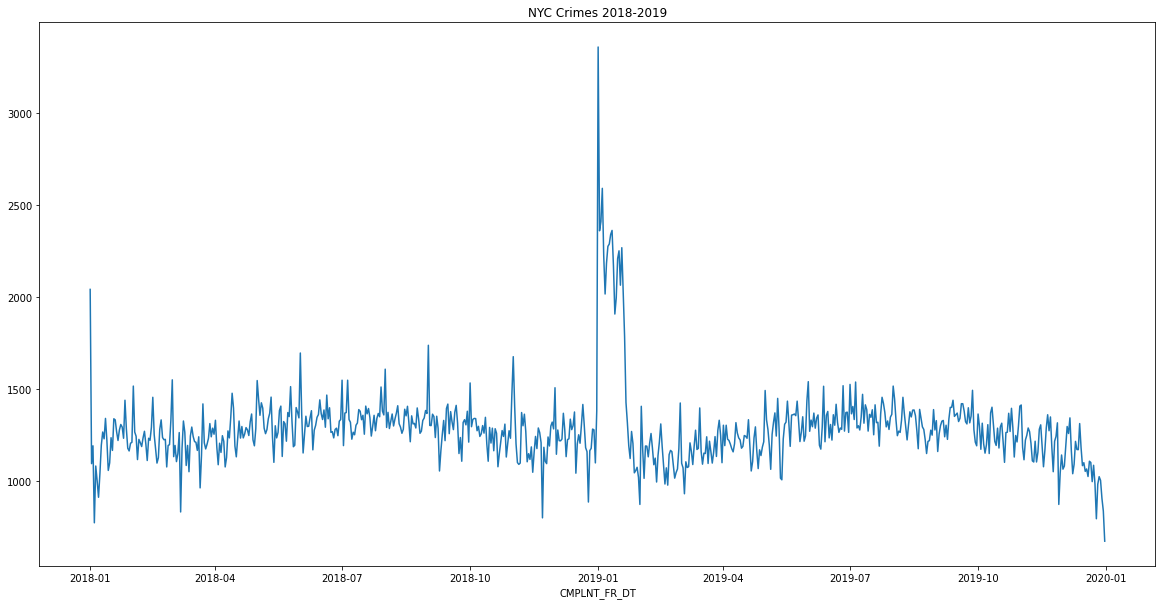

In [11]:
nyc_crime.groupby('CMPLNT_FR_DT').CMPLNT_NUM.count().plot.line(figsize=(20,10), title="NYC Crimes 2018-2019")

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


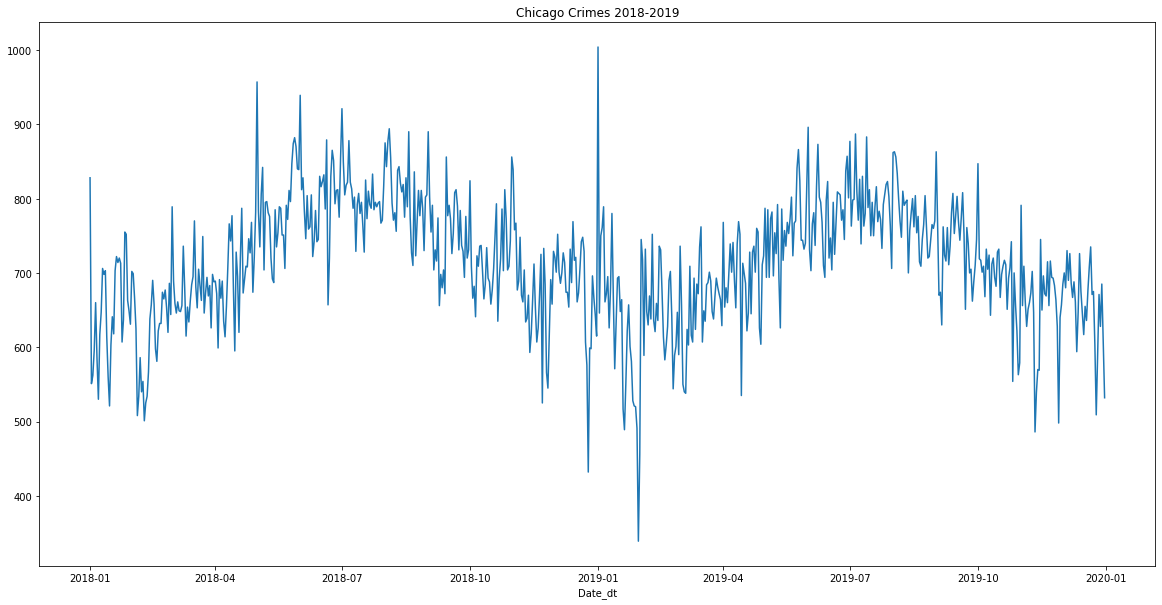

In [12]:
chi_crime.groupby('Date_dt').ID.count().plot.line(figsize=(20,10), title="Chicago Crimes 2018-2019")

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


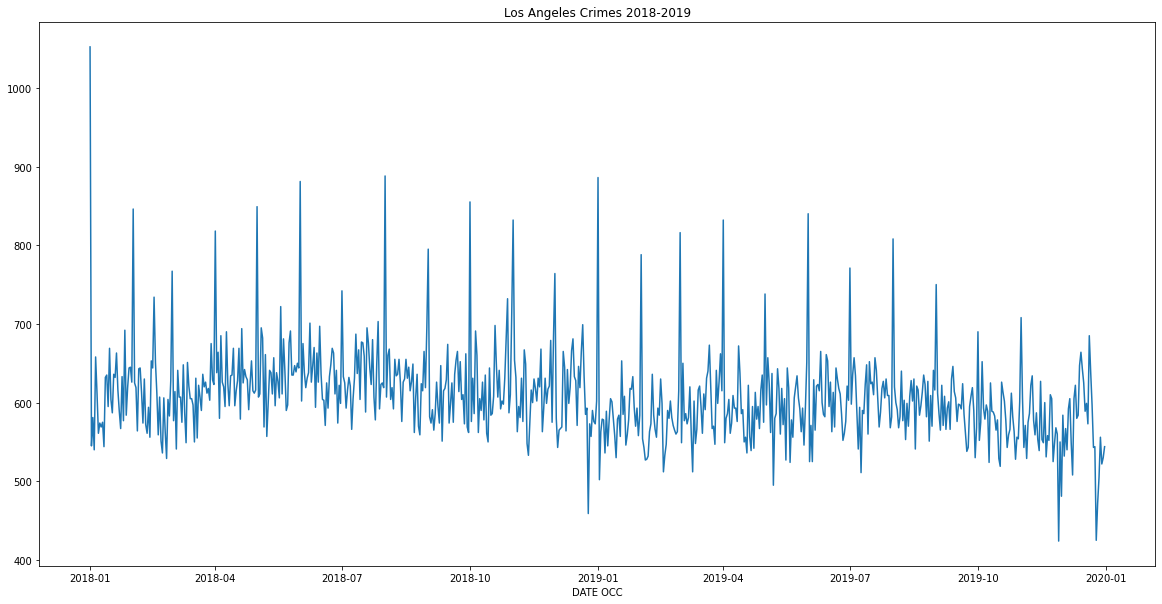

In [13]:
la_crime.groupby('DATE OCC').DR_NO.count().plot.line(figsize=(20,10), title="Los Angeles Crimes 2018-2019")


# Predicció comparada per ciutats (cadascuna per districtes)

In [14]:
chi_district_crime = pd.pivot_table(chi_crime, values='ID', index='Date_dt', columns=['District'], aggfunc='count', fill_value=0)
print (chi_district_crime.shape)

la_district_crime = pd.pivot_table(la_crime, values='DR_NO', index='DATE OCC', columns=['AREA NAME'], aggfunc='count', fill_value=0)
print (la_district_crime.shape)

nyc_district_crime = pd.pivot_table(nyc_crime, values='CMPLNT_NUM', index='CMPLNT_FR_DT', columns=['JURIS_DESC'], aggfunc='count', fill_value=0)
print (nyc_district_crime.shape)

(730, 23)
(730, 21)
(730, 19)


In [15]:
# split into train and test sets
dataIniciTest = datetime.date(year=2019,month=12,day=1)
dataIniciVal = datetime.date(year=2019,month=10,day=1)

testList=[]
validationList=[]
trainList=[]

for df in [chi_district_crime, la_district_crime, nyc_district_crime]: 
    testList.append(df[df.index>=dataIniciTest])
    validationList.append(df[(df.index>=dataIniciVal) & (df.index<dataIniciTest)])
    trainList.append(df[df.index<dataIniciVal])

# normalize the dataset
for i in range(3): 
    scaler = MinMaxScaler()
    scaler.fit(trainList[i])
    trainList[i] = scaler.transform(trainList[i])
    validationList[i] = scaler.transform(validationList[i])
    testList[i] = scaler.transform(testList[i])

In [16]:
n_input = 7
n_featuresList = [] 
for df in [chi_district_crime, la_district_crime, nyc_district_crime]: 
    n_featuresList.append(len(df.columns))

trainGeneratorList = []
validGeneratorList = []
testGeneratorList = []

for i in range(3): 
    trainGeneratorList.append(TimeseriesGenerator(trainList[i], trainList[i], length=n_input, batch_size=1))
    validGeneratorList.append(TimeseriesGenerator(validationList[i], validationList[i], length=n_input))
    testGeneratorList.append(TimeseriesGenerator(testList[i], testList[i], length=n_input))

Entrenem un model per a cadascuna de les ciutats. El model té 2 capes LSTM, de 200 cel·les. El nombre de neurones de la capa de sortida ve determinat pel nombre de districtes de la ciutat. Els models s'entrenen durant 100 èpoques. 

In [17]:
import time
n_epochs = 100
L_results=[]
start = time.time() 
startModelTime= time.time()
model1 = Sequential()
model1.add(LSTM(200, activation='relu', input_shape=(n_input, n_featuresList[0]), return_sequences=True))
model1.add(LSTM(200))
model1.add(Dense(n_featuresList[0]))
model1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model1.summary()
mfit = model1.fit_generator(trainGeneratorList[0], validation_data=validGeneratorList[0], epochs=n_epochs)
L_results.append(['Chicago', mfit])
print ('Temps execució del model {} sec\n'.format(time.time() - startModelTime))
print ('Temps execució acumulada {} sec\n'.format(time.time() - start))

startModelTime= time.time()
model2 = Sequential()
model2.add(LSTM(200, activation='relu', input_shape=(n_input, n_featuresList[1]), return_sequences=True))
model2.add(LSTM(200))
model2.add(Dense(n_featuresList[1]))
model2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model2.summary()
mfit = model2.fit_generator(trainGeneratorList[1], validation_data=validGeneratorList[1], epochs=n_epochs)
L_results.append(['Los Angeles', mfit])
print ('Temps execució del model {} sec\n'.format(time.time() - startModelTime))
print ('Temps execució acumulada {} sec\n'.format(time.time() - start))

startModelTime= time.time()
model3 = Sequential()
model3.add(LSTM(200, activation='relu', input_shape=(n_input, n_featuresList[2]), return_sequences=True))
model3.add(LSTM(200))
model3.add(Dense(n_featuresList[2]))
model3.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model3.summary()
mfit = model3.fit_generator(trainGeneratorList[2], validation_data=validGeneratorList[2], epochs=n_epochs)
L_results.append(['New York', mfit])
print ('Temps execució del model {} sec\n'.format(time.time() - startModelTime))
print ('Temps execució acumulada {} sec\n'.format(time.time() - start))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 200)            179200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 23)                4623      
Total params: 504,623
Trainable params: 504,623
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
631/631 [==============================] - 19s 31ms/step - loss: 0.0233 - acc: 0.0840 - val_loss: 0.0184 - val_acc: 0.1296
Epoch 2/100
631/631 [==============================] - 23s 36ms/step - loss: 0.0211 - acc: 0.1315 - val_loss: 0.0181 - val_acc: 0.1852
Epoch 3/100
631/631 [==============================] - 20s 32ms/step - loss: 0.0205 - acc: 0.1220 - val_loss: 0.0176 - val_acc: 0.

Epoch 56/100
631/631 [==============================] - 16s 25ms/step - loss: 0.0070 - acc: 0.5261 - val_loss: 0.0269 - val_acc: 0.0741
Epoch 57/100
631/631 [==============================] - 15s 24ms/step - loss: 0.0064 - acc: 0.5515 - val_loss: 0.0257 - val_acc: 0.0556
Epoch 58/100
631/631 [==============================] - 15s 24ms/step - loss: 0.0061 - acc: 0.5737 - val_loss: 0.0270 - val_acc: 0.0926
Epoch 59/100
631/631 [==============================] - 16s 25ms/step - loss: 0.0056 - acc: 0.5848 - val_loss: 0.0269 - val_acc: 0.0926
Epoch 60/100
631/631 [==============================] - 19s 30ms/step - loss: 0.0053 - acc: 0.6022 - val_loss: 0.0259 - val_acc: 0.0556
Epoch 61/100
631/631 [==============================] - 18s 28ms/step - loss: 0.0048 - acc: 0.6434 - val_loss: 0.0286 - val_acc: 0.1111
Epoch 62/100
631/631 [==============================] - 25s 39ms/step - loss: 0.0045 - acc: 0.6450 - val_loss: 0.0286 - val_acc: 0.0926
Epoch 63/100
631/631 [==========================

631/631 [==============================] - 14s 22ms/step - loss: 0.0193 - acc: 0.1616 - val_loss: 0.0187 - val_acc: 0.1852
Epoch 11/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0193 - acc: 0.1569 - val_loss: 0.0181 - val_acc: 0.1852
Epoch 12/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0192 - acc: 0.1791 - val_loss: 0.0180 - val_acc: 0.1852
Epoch 13/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0191 - acc: 0.1632 - val_loss: 0.0196 - val_acc: 0.1852
Epoch 14/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0191 - acc: 0.1616 - val_loss: 0.0172 - val_acc: 0.1667
Epoch 15/100
631/631 [==============================] - 14s 23ms/step - loss: 0.0190 - acc: 0.1648 - val_loss: 0.0184 - val_acc: 0.1667
Epoch 16/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0189 - acc: 0.1759 - val_loss: 0.0184 - val_acc: 0.1667
Epoch 17/100
631/631 [==============================] - 15s 2

631/631 [==============================] - 14s 22ms/step - loss: 0.0022 - acc: 0.7401 - val_loss: 0.0272 - val_acc: 0.1296
Epoch 71/100
631/631 [==============================] - 14s 23ms/step - loss: 0.0020 - acc: 0.7575 - val_loss: 0.0270 - val_acc: 0.1296
Epoch 72/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0020 - acc: 0.7734 - val_loss: 0.0273 - val_acc: 0.1481
Epoch 73/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0021 - acc: 0.7417 - val_loss: 0.0276 - val_acc: 0.1481
Epoch 74/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0018 - acc: 0.7765 - val_loss: 0.0254 - val_acc: 0.2037
Epoch 75/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0017 - acc: 0.7686 - val_loss: 0.0264 - val_acc: 0.1667
Epoch 76/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0017 - acc: 0.7829 - val_loss: 0.0259 - val_acc: 0.1481
Epoch 77/100
631/631 [==============================] - 15s 2

631/631 [==============================] - 14s 22ms/step - loss: 0.0084 - acc: 0.5008 - val_loss: 0.0209 - val_acc: 0.2222
Epoch 25/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0079 - acc: 0.5055 - val_loss: 0.0221 - val_acc: 0.1852
Epoch 26/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0075 - acc: 0.5277 - val_loss: 0.0225 - val_acc: 0.1111
Epoch 27/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0068 - acc: 0.5483 - val_loss: 0.0232 - val_acc: 0.1852
Epoch 28/100
631/631 [==============================] - 15s 24ms/step - loss: 0.0064 - acc: 0.5642 - val_loss: 0.0214 - val_acc: 0.1667
Epoch 29/100
631/631 [==============================] - 14s 22ms/step - loss: 0.0057 - acc: 0.5705 - val_loss: 0.0224 - val_acc: 0.1111
Epoch 30/100
631/631 [==============================] - 15s 24ms/step - loss: 0.0052 - acc: 0.6165 - val_loss: 0.0232 - val_acc: 0.1852
Epoch 31/100
631/631 [==============================] - 14s 2

631/631 [==============================] - 14s 22ms/step - loss: 5.4882e-04 - acc: 0.9017 - val_loss: 0.0201 - val_acc: 0.2037
Epoch 84/100
631/631 [==============================] - 15s 23ms/step - loss: 5.7036e-04 - acc: 0.8827 - val_loss: 0.0211 - val_acc: 0.1852
Epoch 85/100
631/631 [==============================] - 15s 24ms/step - loss: 5.7320e-04 - acc: 0.8906 - val_loss: 0.0202 - val_acc: 0.2037
Epoch 86/100
631/631 [==============================] - 14s 21ms/step - loss: 5.8322e-04 - acc: 0.8906 - val_loss: 0.0206 - val_acc: 0.1667
Epoch 87/100
631/631 [==============================] - 14s 22ms/step - loss: 5.7795e-04 - acc: 0.8811 - val_loss: 0.0205 - val_acc: 0.1296
Epoch 88/100
631/631 [==============================] - 14s 22ms/step - loss: 5.5376e-04 - acc: 0.8859 - val_loss: 0.0201 - val_acc: 0.2222
Epoch 89/100
631/631 [==============================] - 13s 21ms/step - loss: 6.0926e-04 - acc: 0.8732 - val_loss: 0.0204 - val_acc: 0.2222
Epoch 90/100
631/631 [===========

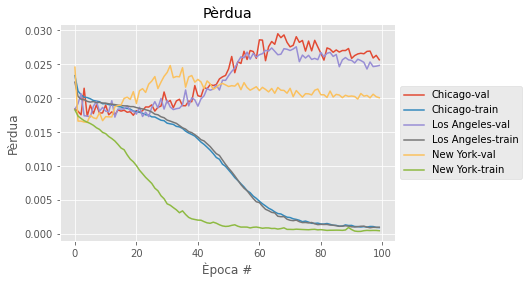

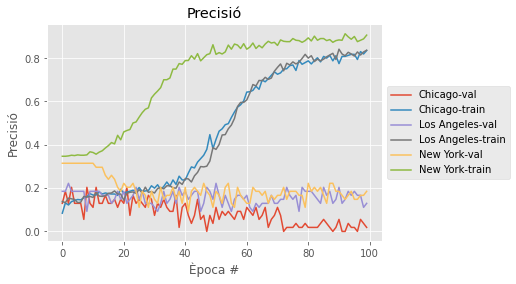

In [18]:
plt.style.use("ggplot")
plt.figure()

for l_res in L_results: 
    plt.plot(np.arange(0, n_epochs), l_res[1].history[list(l_res[1].history.keys())[0]], label=l_res[0]+"-val")
    plt.plot(np.arange(0, n_epochs), l_res[1].history[list(l_res[1].history.keys())[2]], label=l_res[0]+"-train")
plt.title("Pèrdua")
plt.xlabel("Època #")
plt.ylabel("Pèrdua")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.xlim(150, 200)
plt.show()
    
plt.figure()
N = 20

for l_res in L_results: 
    plt.plot(np.arange(0, n_epochs), l_res[1].history[list(l_res[1].history.keys())[1]], label=l_res[0]+"-val")
    plt.plot(np.arange(0, n_epochs), l_res[1].history[list(l_res[1].history.keys())[3]], label=l_res[0]+"-train")
plt.title("Precisió")
plt.xlabel("Època #")
plt.ylabel("Precisió")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.xlim(100,200)
plt.show()

In [19]:
n_input = 28
n_featuresList = [] 
for df in [chi_district_crime, la_district_crime, nyc_district_crime]: 
    n_featuresList.append(len(df.columns))

trainGeneratorList = []
validGeneratorList = []
testGeneratorList = []

for i in range(3): 
    trainGeneratorList.append(TimeseriesGenerator(trainList[i], trainList[i], length=n_input, batch_size=1))
    validGeneratorList.append(TimeseriesGenerator(validationList[i], validationList[i], length=n_input))
    testGeneratorList.append(TimeseriesGenerator(testList[i], testList[i], length=n_input))

import time
n_epochs = 100
L_results2=[]
start = time.time() 
startModelTime= time.time()
model4 = Sequential()
model4.add(LSTM(200, activation='relu', input_shape=(n_input, n_featuresList[0]), return_sequences=True))
model4.add(LSTM(200))
model4.add(Dense(n_featuresList[0]))
model4.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model4.summary()
mfit = model4.fit_generator(trainGeneratorList[0], validation_data=validGeneratorList[0], epochs=n_epochs)
L_results2.append(['Chicago', mfit])
print ('Temps execució del model {} sec\n'.format(time.time() - startModelTime))
print ('Temps execució acumulada {} sec\n'.format(time.time() - start))

startModelTime= time.time()
model5 = Sequential()
model5.add(LSTM(200, activation='relu', input_shape=(n_input, n_featuresList[1]), return_sequences=True))
model5.add(LSTM(200))
model5.add(Dense(n_featuresList[1]))
model5.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model5.summary()
mfit = model5.fit_generator(trainGeneratorList[1], validation_data=validGeneratorList[1], epochs=n_epochs)
L_results2.append(['Los Angeles', mfit])
print ('Temps execució del model {} sec\n'.format(time.time() - startModelTime))
print ('Temps execució acumulada {} sec\n'.format(time.time() - start))

startModelTime= time.time()
model6 = Sequential()
model6.add(LSTM(200, activation='relu', input_shape=(n_input, n_featuresList[2]), return_sequences=True))
model6.add(LSTM(200))
model6.add(Dense(n_featuresList[2]))
model6.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model6.summary()
mfit = model6.fit_generator(trainGeneratorList[2], validation_data=validGeneratorList[2], epochs=n_epochs)
L_results2.append(['New York', mfit])
print ('Temps execució del model {} sec\n'.format(time.time() - startModelTime))
print ('Temps execució acumulada {} sec\n'.format(time.time() - start))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 28, 200)           179200    
_________________________________________________________________
lstm_8 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_4 (Dense)              (None, 23)                4623      
Total params: 504,623
Trainable params: 504,623
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
610/610 [==============================] - 34s 55ms/step - loss: 0.0232 - acc: 0.1016 - val_loss: 0.0193 - val_acc: 0.2727
Epoch 2/100
610/610 [==============================] - 32s 53ms/step - loss: 0.0212 - acc: 0.1033 - val_loss: 0.0245 - val_acc: 0.0303
Epoch 3/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0206 - acc: 0.1279 - val_loss: 0.0208 - val_acc: 0.

Epoch 56/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0084 - acc: 0.4721 - val_loss: 0.0270 - val_acc: 0.0909
Epoch 57/100
610/610 [==============================] - 31s 50ms/step - loss: 0.0078 - acc: 0.5098 - val_loss: 0.0279 - val_acc: 0.0909
Epoch 58/100
610/610 [==============================] - 32s 52ms/step - loss: 0.0074 - acc: 0.5328 - val_loss: 0.0273 - val_acc: 0.0909
Epoch 59/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0069 - acc: 0.5197 - val_loss: 0.0267 - val_acc: 0.0606
Epoch 60/100
610/610 [==============================] - 31s 50ms/step - loss: 0.0066 - acc: 0.5295 - val_loss: 0.0255 - val_acc: 0.0909
Epoch 61/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0061 - acc: 0.5492 - val_loss: 0.0282 - val_acc: 0.0909
Epoch 62/100
610/610 [==============================] - 33s 55ms/step - loss: 0.0057 - acc: 0.5639 - val_loss: 0.0272 - val_acc: 0.1212
Epoch 63/100
610/610 [==========================

610/610 [==============================] - 31s 50ms/step - loss: 0.0193 - acc: 0.1492 - val_loss: 0.0186 - val_acc: 0.2424
Epoch 11/100
610/610 [==============================] - 31s 50ms/step - loss: 0.0193 - acc: 0.1557 - val_loss: 0.0178 - val_acc: 0.2424
Epoch 12/100
610/610 [==============================] - 32s 53ms/step - loss: 0.0193 - acc: 0.1541 - val_loss: 0.0183 - val_acc: 0.0909
Epoch 13/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0192 - acc: 0.1574 - val_loss: 0.0185 - val_acc: 0.2121
Epoch 14/100
610/610 [==============================] - 31s 50ms/step - loss: 0.0192 - acc: 0.1541 - val_loss: 0.0177 - val_acc: 0.2424
Epoch 15/100
610/610 [==============================] - 32s 52ms/step - loss: 0.0192 - acc: 0.1508 - val_loss: 0.0192 - val_acc: 0.2424
Epoch 16/100
610/610 [==============================] - 32s 52ms/step - loss: 0.0191 - acc: 0.1672 - val_loss: 0.0186 - val_acc: 0.2424
Epoch 17/100
610/610 [==============================] - 31s 5

610/610 [==============================] - 32s 52ms/step - loss: 0.0033 - acc: 0.7066 - val_loss: 0.0283 - val_acc: 0.1515
Epoch 71/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0029 - acc: 0.6902 - val_loss: 0.0296 - val_acc: 0.1515
Epoch 72/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0027 - acc: 0.7033 - val_loss: 0.0284 - val_acc: 0.0606
Epoch 73/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0025 - acc: 0.7377 - val_loss: 0.0319 - val_acc: 0.0303
Epoch 74/100
610/610 [==============================] - 32s 52ms/step - loss: 0.0023 - acc: 0.7131 - val_loss: 0.0290 - val_acc: 0.0909
Epoch 75/100
610/610 [==============================] - 32s 52ms/step - loss: 0.0021 - acc: 0.7443 - val_loss: 0.0283 - val_acc: 0.0303
Epoch 76/100
610/610 [==============================] - 31s 50ms/step - loss: 0.0020 - acc: 0.7721 - val_loss: 0.0291 - val_acc: 0.1212
Epoch 77/100
610/610 [==============================] - 30s 5

610/610 [==============================] - 33s 55ms/step - loss: 0.0107 - acc: 0.4279 - val_loss: 0.0227 - val_acc: 0.2121
Epoch 25/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0102 - acc: 0.4656 - val_loss: 0.0225 - val_acc: 0.1212
Epoch 26/100
610/610 [==============================] - 33s 54ms/step - loss: 0.0098 - acc: 0.4443 - val_loss: 0.0239 - val_acc: 0.1212
Epoch 27/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0095 - acc: 0.4541 - val_loss: 0.0241 - val_acc: 0.0909
Epoch 28/100
610/610 [==============================] - 32s 53ms/step - loss: 0.0091 - acc: 0.4836 - val_loss: 0.0240 - val_acc: 0.1818
Epoch 29/100
610/610 [==============================] - 32s 52ms/step - loss: 0.0086 - acc: 0.5098 - val_loss: 0.0244 - val_acc: 0.1818
Epoch 30/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0081 - acc: 0.5115 - val_loss: 0.0241 - val_acc: 0.1212
Epoch 31/100
610/610 [==============================] - 31s 5

Epoch 84/100
610/610 [==============================] - 31s 51ms/step - loss: 5.8413e-04 - acc: 0.9000 - val_loss: 0.0233 - val_acc: 0.2424
Epoch 85/100
610/610 [==============================] - 31s 51ms/step - loss: 6.1029e-04 - acc: 0.8885 - val_loss: 0.0235 - val_acc: 0.2424
Epoch 86/100
610/610 [==============================] - 33s 54ms/step - loss: 5.7683e-04 - acc: 0.8984 - val_loss: 0.0236 - val_acc: 0.2424
Epoch 87/100
610/610 [==============================] - 31s 51ms/step - loss: 5.8009e-04 - acc: 0.9066 - val_loss: 0.0236 - val_acc: 0.2424
Epoch 88/100
610/610 [==============================] - 31s 50ms/step - loss: 5.8652e-04 - acc: 0.8902 - val_loss: 0.0235 - val_acc: 0.2424
Epoch 89/100
610/610 [==============================] - 32s 52ms/step - loss: 6.0937e-04 - acc: 0.9033 - val_loss: 0.0235 - val_acc: 0.1818
Epoch 90/100
610/610 [==============================] - 33s 54ms/step - loss: 4.8167e-04 - acc: 0.9000 - val_loss: 0.0234 - val_acc: 0.2121
Epoch 91/100
610/610

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


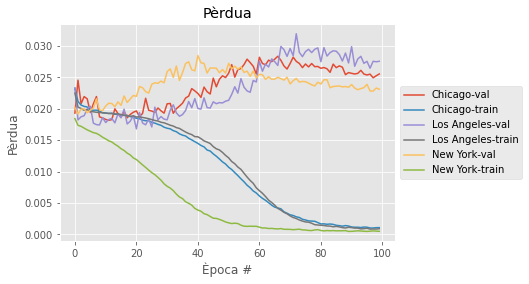

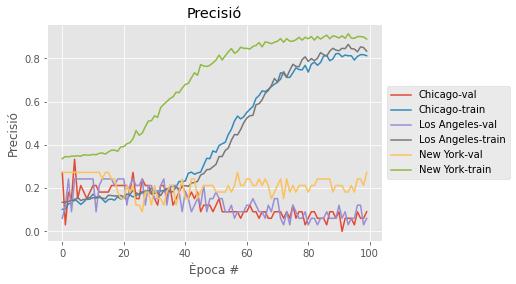

In [20]:
for l_res in L_results2: 
    print (l_res[1].history.keys())
    plt.plot(np.arange(0, n_epochs), l_res[1].history[list(l_res[1].history.keys())[0]], label=l_res[0]+"-val")
    plt.plot(np.arange(0, n_epochs), l_res[1].history[list(l_res[1].history.keys())[2]], label=l_res[0]+"-train")
plt.title("Pèrdua")
plt.xlabel("Època #")
plt.ylabel("Pèrdua")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.xlim(150, 200)
plt.show()
    
plt.figure()
N = 20

for l_res in L_results2: 
    plt.plot(np.arange(0, n_epochs), l_res[1].history[list(l_res[1].history.keys())[1]], label=l_res[0]+"-val")
    plt.plot(np.arange(0, n_epochs), l_res[1].history[list(l_res[1].history.keys())[3]], label=l_res[0]+"-train")
plt.title("Precisió")
plt.xlabel("Època #")
plt.ylabel("Precisió")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.xlim(100,200)
plt.show()